In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

sns.set()

In [135]:
# read in the sparse dataset
dataset = pd.read_csv(
		'../data/run-of-river_production_load_sparse.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime,
			"Date": pd.to_datetime
    })

dataset['epochdate'] = dataset['Date_Time'].map(pd.Timestamp.timestamp).astype(np.float32)
dataset_norm = dataset.drop(columns=['Date','Date_Time']).values
dataset_norm = (dataset_norm - dataset_norm.mean(0)) / dataset_norm.std(0)

/tmp/ipykernel_3212/3497461529.py:2: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  dataset = pd.read_csv(
/tmp/ipykernel_3212/3497461529.py:2: ParserWarning: Both a converter and dtype were specified for column Date - only the converter will be used.
  dataset = pd.read_csv(


In [136]:
# load the PowerEX predictions
predictions = pd.read_csv(
		'../data/mve_predictions_hourly_2022.csv', 
		dtype=np.float32,
		converters={
			"Date_Time": pd.to_datetime
    })

predictions = predictions.drop_duplicates()

/tmp/ipykernel_3212/732643380.py:2: ParserWarning: Both a converter and dtype were specified for column Date_Time - only the converter will be used.
  predictions = pd.read_csv(


In [137]:
# import the model torch.nn.Module
from all_S2S_models import S2S_BA_Model

In [147]:
def load_model(cell_type = 'lstm', window_source_size=168,window_target_size=48, hs = 24):
    # load the trained weights into the model
    
    
    checkpoint = torch.load(
        'tuning/models/MODEL_w:__seed=0_cell_type='+cell_type+ \
            '_attention_model=BA_la_method=none_T='+str(window_source_size)+ \
                '_N='+str(window_target_size)+'_bs=128_hs='+str(hs), \
                    map_location=torch.device('cpu'))

    model = S2S_BA_Model(cell_type, 44, hs, False)
    model.load_state_dict(checkpoint)

    return model

<All keys matched successfully>

In [148]:
def get_predictions(model, start_index=18400, window_source_size=168, window_target_size=48):

    # retrieve range of dates for these indices
    dates = dataset['Date_Time'][start_index+window_source_size:start_index+window_source_size+window_target_size]

    # create the prediction (note the names of the functions may differ for your model)
    pred = model.predict(*model.consume(
        torch.from_numpy(np.array(
            [dataset_norm[start_index:start_index+window_source_size, :]]
        ))), window_target_size).detach().numpy().flatten()

    # extract the prediction arrays
    actual = dataset['Value'][start_index+window_source_size:start_index+window_source_size+window_target_size]
    preds = pred * dataset['Value'].std() + dataset['Value'].mean()
    powerex = predictions[np.logical_and(predictions['Date_Time'] >= dates.min(), predictions['Date_Time'] <= dates.max())]

    return dates, actual, preds, powerex

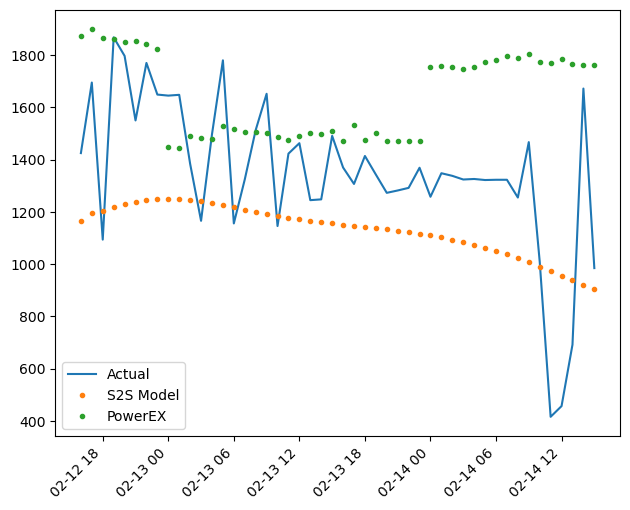

In [149]:
for cell_type in ['lstm', 'gru', 'rnn']:
    model = load_model(cell_type, 168, 48, 48)

    dates, actual, preds, powerex = get_predictions(model, 168, 48)
    plt.plot(dates, preds, '.', label='S2S Model ({})'.format(cell_type))

# plot
plt.plot(dates, actual, label='Actual')
plt.plot(powerex['Date_Time'], powerex['prediction'], '.', label='PowerEX')
plt.legend()
plt.gcf().tight_layout()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Sample Prediction");

In [150]:
def get_error_metrics(actual, pred, title="ERRORS"):
    mae = (sum(abs(actual - pred)))/(len(actual))
    mape = (sum(abs((actual - pred)/actual))) / (len(actual))
    smape = (sum(abs(actual - pred)/(abs(actual)+abs(pred)))) / (len(actual))
    rmse = np.sqrt(np.mean((actual - pred)**2))

    print("###### "+title+" ######")
    print("MAE:", mae)
    print("MAPE:", mape*100.0,"%")
    print("SMAPE:", smape*100.0,"%")
    print("RMSE:", rmse)

    return mae, mape, smape, rmse

In [151]:
get_error_metrics(actual, preds, "ACTUAL VS MODEL")

###### ACTUAL VS MODEL ######
MAE: 281.8501230875651
MAPE: 22.867369651794434 %
SMAPE: 11.510839784750715 %
RMSE: 328.6437


(281.8501230875651, 0.22867369651794434, 0.11510839784750715, 328.6437)

In [152]:
actual_powerex = dataset.set_index('Date_Time').loc[powerex['Date_Time']]['Value'].values
get_error_metrics(actual_powerex, powerex['prediction'], "ACTUAL VS POWEREX")

###### ACTUAL VS POWEREX ######
MAE: 328.979242960612
MAPE: 35.74185865242423 %
SMAPE: 11.850169889900524 %
RMSE: 451.66052


(328.979242960612, 0.35741858652424224, 0.11850169889900523, 451.66052)

In [153]:
model_errors = []
powerex_errors = []
for i in range(17546, 20000):
    dates, actual, preds, powerex = get_predictions(i)
    model_errors.append(list(get_error_metrics(actual, preds, "ACTUAL VS MODEL")))
    actual_powerex = dataset.set_index('Date_Time').loc[powerex['Date_Time']]['Value'].values
    powerex_errors.append(list(get_error_metrics(actual_powerex, powerex['prediction'], "ACTUAL VS POWEREX")))

###### ACTUAL VS MODEL ######
MAE: 506.0482978820801
MAPE: 29.540118602259707 %
SMAPE: 18.17333665676415 %
RMSE: 593.28827
###### ACTUAL VS POWEREX ######
MAE: 614.0598805745443
MAPE: 43.93447926025449 %
SMAPE: 16.894844705287447 %
RMSE: 690.9818
###### ACTUAL VS MODEL ######
MAE: 443.88161849975586
MAPE: 25.670871409753698 %
SMAPE: 15.416719655634855 %
RMSE: 534.36334
###### ACTUAL VS POWEREX ######
MAE: 603.7549107869467
MAPE: 43.43390706223242 %
SMAPE: 16.671681308677456 %
RMSE: 687.2489
###### ACTUAL VS MODEL ######
MAE: 402.0392367045085
MAPE: 23.43372381389296 %
SMAPE: 13.85955368168652 %
RMSE: 489.34424
###### ACTUAL VS POWEREX ######
MAE: 600.4002405802408
MAPE: 43.36565241756034 %
SMAPE: 16.642271802629693 %
RMSE: 685.81604
###### ACTUAL VS MODEL ######
MAE: 375.99755732218426
MAPE: 22.199845484768353 %
SMAPE: 13.015753228683025 %
RMSE: 461.15134
###### ACTUAL VS POWEREX ######
MAE: 596.7800369262695
MAPE: 43.24617700258386 %
SMAPE: 16.58801984898067 %
RMSE: 684.7414
###### AC

In [154]:
errors = ["MAE", "MAPE", "SMAPE", "RMSE"]
df_model = pd.DataFrame.from_records(model_errors, columns=errors).replace([np.inf, -np.inf], np.nan)
df_powerex = pd.DataFrame.from_records(powerex_errors, columns=errors).replace([np.inf, -np.inf], np.nan)

Model Mean MAE 424.8699444561217
PowerEX Mean MAE 385.03284231969974


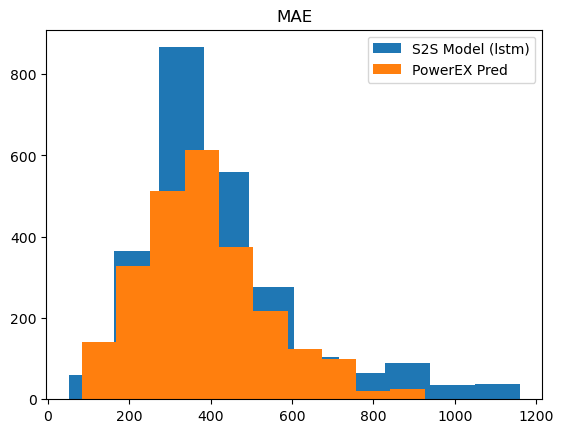

Model Mean MAPE 1.0323894948253187
PowerEX Mean MAPE 1.1572013199706028


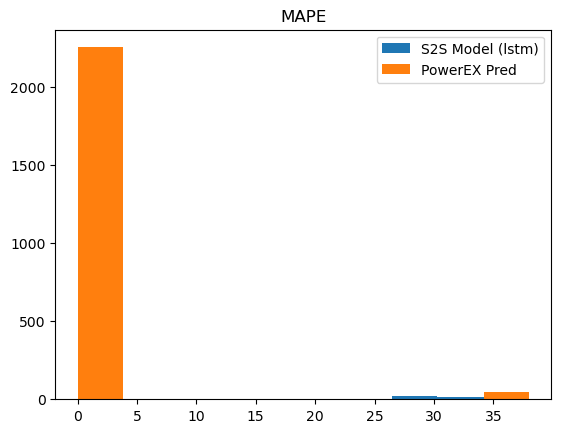

Model Mean SMAPE 0.17691318985093077
PowerEX Mean SMAPE 0.153380709064414


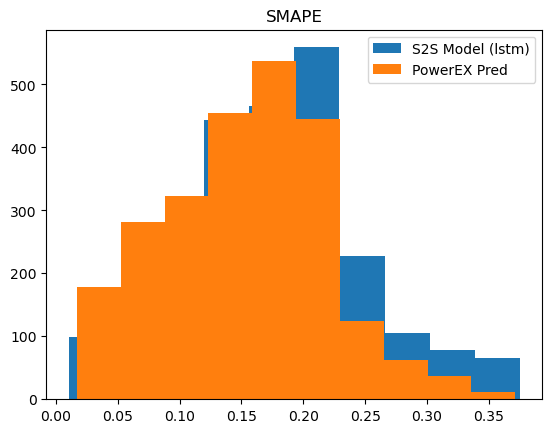

Model Mean RMSE 497.31644
PowerEX Mean RMSE 464.4177


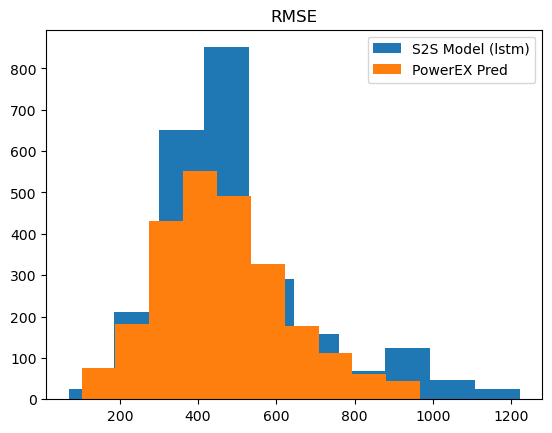

In [155]:
for error in errors:
    print("Model Mean", error, df_model[error].mean())
    print("PowerEX Mean", error, df_powerex[error].mean())
    plt.hist(df_model[error], 10, label="S2S Model ("+cell_type+")")
    plt.hist(df_powerex[error], 10, label="PowerEX Pred")
    plt.legend()
    plt.title(error)
    plt.show()